# Random Forest

Como vimos, se agregarmos as predições de um grupo de preditores, geralmente obteremos predições melhores quando comparadas às de um preditor individual. Um grupo de preditores é chamado *ensemble*. 

Como exemplo de um método *ensemble*, podemos treinar um grupo de Árvores de Decisão, cada uma num subconjunto aleatório do conjunto de treino. Para fazer predições, obteremos as predições de cada árvore e a predição final será a classe que tiver o maior número de votos (classificação) ou a média (regressão). 

Tal método *ensemble* de Árvores de Decisão é conhecido como **Random Forest**. 

## Voting Classifiers

Para entender melhor como funcionam as Random Forest, vamos entender o conceito de Voting Classifiers. Suponha que voce tenha treinado alguns classificadores, cada um alcançando aproximadamente 80% de acurácia. Uma maneira muito simples de criar um classificador ainda melhor é agregar as predições de cadda classificador e predizer a classe que recebeu a maioria dos votos (*hard voting classifier*).

Surpreendentemente, esse *voting classifier* geralmente alcança uma acurácia maior que o melhor classificador no *ensemble*. De fato, mesmo que cada classificador seja um **weak learner**, o *ensemble* ainda pode ser um **strong learner** (alcançando maior acurácia), desde que um número suficiente de *weak learners* seja providenciado e que eles suficientemente diversos.

Considere o código abaixo para entender o funcionamento de um *Voting Classifier*.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [3]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [4]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


Se todos os classificadores são capazes de estimar probabilidades das classes (ou seja, possuem o método *predict_proba*), então é possível predizer a classe usando aquela que obteve a maior probabilidade. Isto é chamado de *soft voting*. Geralmente alcança performance maior que o *hard voting* visto que dá mais peso para votos mais confidentes. Para isso, altere o hiperparâmetro *voting=hard* parra *voting=soft*.

Lembrando que, para o caso do SVC, precisamos alterar o hiperparâmetro *probability* parra True para que ele calcule as probabilidades. 

In [5]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [6]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## Bagging

Como vimos, *bagging* é o conceito de criar um dataset usando amostragem com reposição e agregar as predições visando fornecer uma estimativa melhor que a de um preditor individual. 

O seguinte código treina um *ensemble* de 500 Árvores de Decisão para classificação, sendo que cada uma é treinada com 100 amostras retiradas aleatoriamente do conjunto de treino e com reposição

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [8]:
print(accuracy_score(y_test, y_pred))

0.904


Comparado a uma simples Árvore de Decisão, podemos observar que a performance é melhor, como visto abaixo:

In [9]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


A figura abaixo compara a fronteira de decisão de uma única Árvore de Decisão com a fronteira de decisão de um *ensemble* usando bagging de 500 árvores (treinado acima), ambas usando o dataset moons.

In [10]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

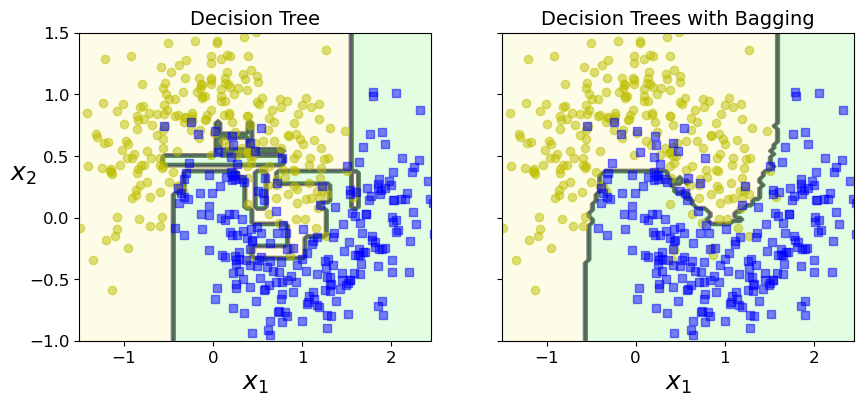

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

Como é possível ver, as predições do *ensemble* provavelmente irão generalizar muito melhor quando comparadas às da Árvore de Decisão. Em outras palavras, o *ensemble* possui um **bias** comparável, mas uma **variância** menor (isto é, comete aproximadamente o mesmo número de erros no conjunto de treinamento, mas a fronteira de decisão é menos irregular).

Assim, podemos dizer que Bootstrapping introduz um pouco mais de diversidade nos subconjuntos em que cada preditor é treinado, o que eleva um pouco o **bias**. Entretanto, essa diversidade extra também significa que os preditores serão menos correlacionados, de modo que a **variância** do *ensemble* é reduzida. 

## Avaliação Out-of-Bag

Com bagging, algumas instâncias podem ser amostradas muitas vezes para um determinado preditor, enquanto outras podem nunca ser amostradas. Por padrão, um *BaggingClassifier* amostra *m* exemplos de treinamento com reposição, em que *m* é o tamanho do conjunto de treino. Isto significa que apenas aproximadamente 67% dos exemplos de treino são amostrados em média para cada preditor. Os 33% restantes que não são amostrados são chamadas amostras *Out-of-Bag*. **Note que elas não são as mesmas para todos os preditores**.

Dado que um preditor nunca verá uma amostra *Out-of-Bag* durante a etapa de treino, ele pode ser avaliado nessas amostras, sem a necessidade de um conjunto separado para validação. 

Na Scikit-Learn, podemos setar o hiperparâmetro *oob_score=True* para querer uma avaliação automática depois do treinamento. O código abaixo demonstra isso:

In [12]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

Agora podemos verificar qual o valor da acurácia obtida no conjunto de teste:

In [13]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

## Random Forest
Como discutimos, uma Random Forest é um *ensemble* de Árvore de Decisão geralmente treinando usando o método bagging. Ao invés de construir um *BaggingClassifier* e passar ele num *DecisionTreeClassifier*, podemos usar a classe *RandomForestClassifier*, que é mais conveniente e otimizada para Árvores de Decisão (podemos usar *RandomForestRegressor* para regressão). Veja o código abaixo:

In [14]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.912

Com algumas exceções, um *RandomForestClassifier* possui todos os hiperparâmetros de um *DecisionTreeClassifier* (para controlar como as árvores crescem) e todos os hiperparâmetros de um *BaggingClassifier* (para controlar o *ensemble* em si). 

O algoritmo Random Forest introduz aleatoriadade extra quando cresce as árvores; ao invés de procurar a melhor feature ao fazer um split, ele procura a melhor feature entre um subconjunto de features, o que resulta em maior diversidade (novamente, um tradeoff entre **bias** e **variance**, levando a um modelo melhor de maneira geral. 

### Feature Importance
Outra grande qualidade das Random Forests é que elas facilitam a medição da importância relativa de cada feature. Scikit-Learn mede a importância de uma feature observando o quanto os nós de árvore que usam essa feature reduzem a impureza em média (entre todas as árvores da floresta). Mais precisamente, é uma média ponderada, onde o peso de cada nó é igual ao número de amostras de treinamento que estão associadas a ele.

Scikit-Learn calcula essa pontuação automaticamente para cada feature após o treinamento e, em seguida, dimensiona os resultados para que a soma de todas as importâncias seja igual a 1. Podemos acessar o resultando usando a variável *feature_importances_*, como mostrado abaixo:

In [15]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


Por fim, podemos ver como Random Forest agrega as fronteiras de decisão de cada árvore individualmente para produzir uma fronteira de decisão mais suavel e que generaliza melhor. 

A figura abaixo apresenta a sobreposição da fronteira de decisão de 15 Árvores de Decisão. Como você pode ver, mesmo que cada árvore de decisão seja imperfeita, o *ensemble* define uma fronteira de decisão muito boa.

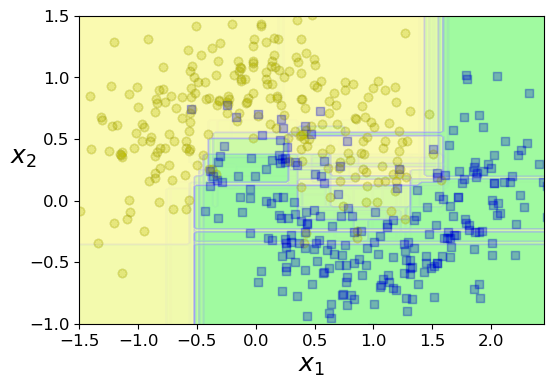

In [16]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()